Transform data into pick-order-&-roles-as-categoricals format, then create a patchy dataset (some features missing) for training models

In [1]:
from Learning import *
from Graphing import *

In [2]:
meta,X,X_rec,Yc,Yr,(meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels) = load_ld("d1,2,4,8,20_all") # Load combo
# meta,X,X_rec,Yc,Yr,(meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels) = load_ld("db1,2,4,8,20_all") # Load combo
# meta,X,X_rec,Yc,Yr,(meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels) = load_ld("fd2,5,12_all_18390") # Load combo

(array([54827.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 10173.]),
 array([420., 422., 424., 426., 428., 430., 432., 434., 436., 438., 440.]),
 <a list of 10 Patch objects>)

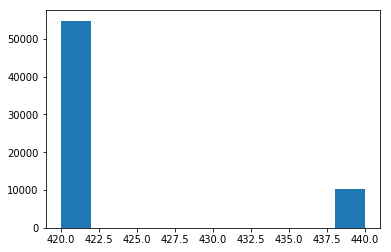

In [7]:
plt.hist(meta[:, meta_labels.index("queue_id")])

In [3]:
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

((72500, 26), (72500, 9708), 9708, (7, 124), 124, (72500, 13), (72500, 160))

Add pick order and player elos to metadata

In [4]:
new_meta_ls = [r + "_elo" for r in t_roles]
meta_labels += new_meta_ls
meta = np.hstack([meta, X[:, [X_labels.index(l) for l in new_meta_ls]]])
new_meta_ls = [r + "_pick_position" for r in t_roles]
meta_labels += new_meta_ls
meta = np.hstack([meta, X[:, [X_labels.index(l) for l in new_meta_ls]]])
meta.shape

(72500, 46)

Remove spells labels (todo: add), first/last season labels, etc

In [5]:
X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "_spell_" in l])
X.shape

(72500, 9508)

In [6]:
X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "_recent_first_season" in l])
X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "_recent_last_season" in l])
X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "_first_ranked_season" in l])
X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "_last_ranked_season" in l])
X.shape

(72500, 9468)

In [7]:
X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "_pick_position" in l])
X.shape

(72500, 9458)

In [8]:
X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "_highest_achieved_season_tier" in l])
X.shape

(72500, 9448)

In [9]:
X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "_champion__x" in l])
X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "patch__x" in l])
X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "season__x" in l])
X.shape

(72500, 8029)

In [10]:
X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "opgg_champion_" in l and (
                                                "_total_wins" in l or "_total_losses" in l)])
X.shape

(72500, 7869)

In [11]:
X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "_tier" in l])
X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "_league_points" in l])
X.shape

(72500, 7819)

In [12]:
X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "_opgg_rs_wins" in l])
X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "_opgg_rs_losses" in l])
X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "_opgg_rs_win_rate" in l])
X.shape

(72500, 7789)

In [13]:
# X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "_rank" in l])
# X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "_turrets" in l])
# X.shape

Save/load checkpoint

In [14]:
save_ld((meta,X,Yc,Yr,(meta_labels,X_labels,Yc_labels,Yr_labels)),"d_lorb")#+str(int(time.time())))

In [15]:
meta,X,Yc,Yr,(meta_labels,X_labels,Yc_labels,Yr_labels) = load_ld("d_lorb") # Load preprocessed data

In [16]:
meta.shape, X.shape, len(X_labels), Yc.shape, Yr.shape

((72500, 46), (72500, 7789), 7789, (72500, 13), (72500, 160))

Shuffle

In [4]:
meta, X, Yc, Yr = shuffle_data([meta, X, Yc, Yr])

Data normalization/feature scaling

In [5]:
print(Yr.min(), X.min(), Yr.max(), X.max()) # Scale data to between 0 & 1 (remember scaling values)
X_scales, X_scalesdict = scale_data(X, X_labels)
Yr_scales, Yr_scalesdict = scale_data(Yr, Yr_labels)
print(Yr.min(), X.min(), Yr.max(), X.max())
# X_scales, X_scalesdict, Yr_scales, Yr_scalesdict = [None] * 4

0.0 -1560585.6048717396 842662.0 1543634370158.0
0.0 -0.4936898387520934 1.0 1.0


In [6]:
# unscale_data(X, X_labels, X_scales) # Unscale
# unscale_data(Yr, Yr_labels, Yr_scales)
# Yr.max(), X.max()

Create each task's dataset (win %, win % over time, duration classification)

In [7]:
X, X_labels = remove_data_subset(X, X_labels, duration_labels)
# X_wot, X_wot_labels = X, X_labels
# duration_label_index = X_wot_labels.index(duration_labels[0])
# X, X_labels =  remove_data_subset(X_wot, X_wot_labels, duration_labels)
# X_dc, Yr_dc, X_dc_labels, Yr_dc_labels = X, X_wot[:, duration_label_index], X_labels, duration_labels[:1]
# X.shape, X_wot.shape, Yr_dc.shape
X.shape

(72500, 7788)

Create winrate approximations using a Beta prior (learn the parameters), remove old win/loss features, [ try adding n_games feature ]

In [8]:
def add_beta_winrates(alpha, beta, X_bopt, X_labels_bopt, incl_n_games=True):
#     n_total = n_train + n_test
    new_X, new_ls = [], []
#     X_bopt = X
#     X_labels_bopt = X_labels
#     X_bopt = X[:n_total].copy()
#     X_labels_bopt = list(X_labels)
    wins_ls = [l for l in X_labels_bopt if l[-5:] == "_wins" and "_eloavg_" not in l and "_opgg_champion_all_" not in l]
    ls_ = [l[:-5] for l in wins_ls]
#     len(ls_)

    unscale_data(X_bopt, X_labels_bopt, X_scales, sc_ls=wins_ls + \
    [l_ + "_losses" for l_ in ls_ if l_ + "_losses" in X_labels_bopt] + \
    [l_ + "_games" for l_ in ls_ if l_ + "_games" in X_labels_bopt])
#     X_bopt.max()

    # X_bopt = RobustScaler().fit_transform(X_bopt)
    n_wls = len(wins_ls)
    wins_arr = np.asarray([X_bopt[:, X_labels_bopt.index(l)] for l in wins_ls])
    # print(wins_arr.shape)
    new_ls = []
    losses_list = []
    losses_ls = []
    games_ls = []
    wr_ls = []
    new_ls = []
    new_ngls = []
    for l_i in range(n_wls):
        l_ = ls_[l_i]
        losses_l = l_ + "_losses"
        games_l = l_ + "_games"
        if losses_l in X_labels_bopt:
            losses_ls.append(losses_l)
            losses_list.append(X_bopt[:, X_labels_bopt.index(losses_l)])
#         elif games_l in X_labels_bopt:
        else:
            games = X_bopt[:, X_labels_bopt.index(games_l)] - wins_arr[l_i]
            losses_list.append(X_bopt[:, X_labels_bopt.index(games_l)] - wins_arr[l_i])
#         else:
#             print("ERROR: " + wins_ls[l_i])
#             continue
        wr_l = l_ + "_win_rate"
        if wr_l in X_labels_bopt:
            wr_ls.append(wr_l)

        new_l = l_ + "_bayes_win_rate"
        new_ls.append(new_l)
        if incl_n_games:
            new_ngl = l_ + "_games"
            new_ngls.append(new_ngl)
    wins_arr = wins_arr.T
    losses_arr = np.vstack(losses_list).T
    # print(wins_arr.shape, losses_arr.shape)
    # print(wins_arr.max(), losses_arr.max(), wins_arr.min(), losses_arr.min())
    n_games_arr = wins_arr + losses_arr
    new_wins_arr = (wins_arr + alpha)
    bayes_wr_arr = new_wins_arr / (new_wins_arr + (losses_arr + beta))
    # wl_data = [wins_arr, losses_arr, bayes_wr_arr] + ([n_games_arr] if incl_n_games else [])

    # del_ls = wins_ls + games_ls + losses_ls + wr_ls
    del_ls = games_ls + wr_ls
#     del_ls = games_ls
    X_bopt, X_labels_bopt = remove_data_subset(X_bopt, X_labels_bopt, del_ls)

    # Add the win rate (and n_games) features
    X_bopt = np.hstack([X_bopt] + ([n_games_arr] if incl_n_games else []) + [bayes_wr_arr])
    X_labels_bopt += new_ls + new_ngls
    
    return X_bopt, X_labels_bopt

In [9]:
# n_train = 10000
# n_test = 1000
# def boptify(x):
#     global wins_arr, n_games_arr, X_bopt, Y_bopt
#     alpha, beta = x
#     wrs = (wins_arr + alpha) / (n_games_arr + (alpha + beta))
#     for i in range(n_wls):
#         X_bopt[:, i - n_wls] = wrs[:, i]
    
#     scores = []
#     X_, Y_ = X_bopt, Y_bopt
#     for i in range(10):
#         X_, Y_ = shuffle_data([X_, Y_])
#         X_train, Y_train = X_[:n_train], Y_[:n_train]
#         X_test, Y_test = X_[-n_test:], Y_[-n_test:]
#         m = get_model("LogisticRegression")
#         if isinstance(m, MultiOutputClassifier):
#             m = m.estimator
#     #     m = FeatSelectWrapper(m)
#         m = Pipeline(steps=
#         [
# #             ('scale', RobustScaler()),
# #             ('scale', StandardScaler()),
#             ('scale', MinMaxScaler()),
#             ('model', m),
#         ])
#         m.fit(X_train, Y_train.flatten())
#         preds = m.predict(X_test)
#         score = np.mean(preds == Y_test.flatten()) * 100
#         scores.append(score)
#     return -np.mean(scores)

In [10]:
# sol = scipy.optimize.minimize(boptify, [alpha, beta], bounds=[(0, 10), (0, 10)],
#                               options={'eps': 1e0, 'gtol': 1e-1, 'disp': True})
# sol
# for n in [2.575, 2.625, 2.65]:
# # for n in [10, 13, 16]:
#     print(boptify((n, n)))

In [11]:
# alpha, beta = 2.5, 2.5
alpha, beta = 1.0, 1.0
# alpha, beta = .5, .5
X, X_labels = add_beta_winrates(alpha, beta, X, X_labels)
X.shape

(72500, 8080)

Define models & variables

In [12]:
model_strs = [
#     "TFNN",
    "LogisticRegression",
#     "SoftmaxRidgeClassifier",
#     "AdaBoostClassifier",
#     "MLPClassifier",
#     "LinearDiscriminantAnalysis",
#     "LinearSVC"
]
y_label = "blue_win"
n_train = 55000
n_test = 10000
n_pcal = 10000
# n_train = 1000
# n_test = 1000
# n_pcal = 1000

Y = Yc[:, Yc_labels.index(y_label)].reshape(-1, 1)
X_train, Y_train, X_pcal, Y_pcal = X[:n_train], Y[:n_train], X[n_train:n_train + n_pcal], Y[n_train:n_train + n_pcal]
X_test, Y_test = X[-n_test:], Y[-n_test:]
meta_train, meta_pcal, meta_test = meta[:n_train], meta[n_train:n_train + n_pcal], meta[-n_test:]
# X_train, Y_train = X[:n_train], Y[:n_train]
# X_test, Y_test = X[-n_test:], Y[-n_test:]
# X_train.shape, X_test.shape
X_train.shape, X_pcal.shape, X_test.shape

((55000, 8080), (10000, 8080), (10000, 8080))

In [13]:
model_dict = {}

In [14]:
rs_labels = [l for l in X_labels if l in sum([[r + '_' + k for k in [
"season_games",
"season_wins",
"season_losses",
"season_win_rate",
"season_bayes_win_rate",
"tier",
"int_tier",
"rank",
"league_points",
"division",
"elo",
"first_ranked_season",
"last_ranked_season",
"n_recent_matches",
]] for r in t_roles], [])]

In [15]:
# perc_full_data = 25
# n_excl = (1.0 - (perc_full_data / 100.0)) * n_train
model_dict_keys = ["n_blue", "n_red", "opgg_blue", "opgg_red", "opgg_blue_prof", "opgg_red_prof", "matchup_stats"]
model_cases_init = list(itertools.product(*([[0, 1 ,5]] * 4)))
model_cases = []
for c in model_cases_init:
    # Skip null case
    if all([c_ == 0 for c_ in c]):
        continue
    
    c_ = list(c)
    
    # 0 = 0
    # 1 = between 1 & 4 (inclusive)
    # 5 = 5
    
    # Matchup features case indicator
    m = [0] # Default is that we have 0 champions for one or both teams, and thus we have no matchup features (0)
    if c[0] == 1 and c[1] == 1: # If we have the ambiguous case where matchups are possible but not guaranteed (1)
        m = [0, 1] # Create two model cases instead of one, for when we do & don't have matchups (uses mean if so)
    elif (c[0] == 1 and c[1] == 5) or (c[0] == 5 and c[1] == 1): # We know between 1 & 4 matchups (2)
        m = [1] # Include matchups feature means
    elif c[0] == 5 and c[1] == 5: # If we have all champions (3)
        m = [5] # Include all matchup features
        
    # Player champion proficiency features indicator (blue team)
    o_b = [0] # Default is that we have 0 opgg profiles or 0 champions, and thus we have no proficiency features (0)
    if c[0] == 1 and c[2] == 1: # If we have the ambiguous case where overlap is possible but not guaranteed (1)
        o_b = [0, 1] # Create two model cases instead of one, for when we do & don't have overlap (uses mean if so)
    elif (c[0] == 1 and c[2] == 5) or (c[0] == 5 and c[2] == 1): # We know between 1 & 4 overlap players (2)
        o_b = [1] # Include proficiency feature means
    elif c[0] == 5 and c[2] == 5: # If we have all champions & opgg profiles (3)
        o_b = [5] # Include all proficiency features
    # Player champion proficiency features indicator (red team)
    o_r = [0]
    if c[1] == 1 and c[3] == 1:
        o_r = [0, 1]
    elif (c[1] == 1 and c[3] == 5) or (c[1] == 5 and c[3] == 1):
        o_r = [1]
    elif c[1] == 5 and c[3] == 5:
        o_r = [5]
    
    # Now, create the final model case(s)
    for c_suffix in itertools.product(o_b, o_r, m):
        model_cases.append(tuple(c_ + list(c_suffix)))

all_matchup_labels = [l for l in X_labels if "chgg_" in l and "matchup_" in l]
matchup_labels = [l for l in X_labels if "chgg_" in l and "matchup_" in l and "synergy" not in l \
                              and "adc_support" not in l and "support_adc" not in l]
matchup_synergy_labels = [l for l in X_labels if "chgg_" in l and "matchup_" in l and ("synergy" in l \
                              or "adc_support" in l or "support_adc" in l)]
matchup_synergy_labels_blue = [l for l in matchup_synergy_labels if l[:5] == "blue_"]
matchup_synergy_labels_red = [l for l in matchup_synergy_labels if l[:4] == "red_"]
matchup_synergy_label_is_blue = [X_labels.index(l) for l in matchup_synergy_labels_blue]
matchup_synergy_label_is_red = [X_labels.index(l) for l in matchup_synergy_labels_red]
matchup_ls_roles = OrderedDict([(r, [l for l in matchup_labels if r in l]) for r in t_roles])
matchup_ls_avgs_blue = [l.replace("blue_top", "blue") for l in matchup_ls_roles["blue_top"]]
matchup_ls_avgs_red = [l.replace("blue_top", "red") for l in matchup_ls_roles["blue_top"]]
matchup_ls_roles_is_blue = \
    dict([(ri, [X_labels.index(l) for l in matchup_ls_roles["blue_" + roles_all[ri]]]) for ri in range_5])
matchup_ls_roles_is_red = \
    dict([(ri, [X_labels.index(l) for l in matchup_ls_roles["red_" + roles_all[ri]]]) for ri in range_5])
matchup_labels_blue = [l for l in matchup_labels if l[:5] == "blue_"]
matchup_labels_red = [l for l in matchup_labels if l[:4] == "red_"]
matchup_label_is_blue = [X_labels.index(l) for l in matchup_labels_blue]
matchup_label_is_red = [X_labels.index(l) for l in matchup_labels_red]
rec_labels = [l for l in X_labels if any([str(n) + "ravg_" in l for n in range(20)])]
opgg_r_labels = [l for l in X_labels if "opgg_rs_" in l or "opgg_champion_" in l or l in rec_labels or l in rs_labels]
opgg_r_ls_roles = OrderedDict([(r, [l for l in opgg_r_labels if r in l]) for r in t_roles])
opgg_r_ls_roles_champ = OrderedDict([(r, [l for l in opgg_r_ls_roles[r] if \
    ("_opgg_champion_recent_" in l or "_opgg_champion_season_" in l) and "ravg_" not in l]) for r in t_roles])
opgg_r_ls_roles_non_champ = OrderedDict([(r, [l for l in opgg_r_ls_roles[r] if \
    l not in opgg_r_ls_roles_champ[r]]) for r in t_roles])
opgg_r_ls_avgs_blue_champ = [l.replace("blue_top", "blue") for l in opgg_r_ls_roles_champ["blue_top"]]
opgg_r_ls_avgs_blue_non_champ = [l.replace("blue_top", "blue") for l in opgg_r_ls_roles_non_champ["blue_top"]]
opgg_r_ls_avgs_red_champ = [l.replace("blue_top", "red") for l in opgg_r_ls_roles_champ["blue_top"]]
opgg_r_ls_avgs_red_non_champ = [l.replace("blue_top", "red") for l in opgg_r_ls_roles_non_champ["blue_top"]]
opgg_r_ls_roles_is_blue = \
    dict([(ri, [X_labels.index(l) for l in opgg_r_ls_roles["blue_" + roles_all[ri]]]) for ri in range_5])
opgg_r_ls_roles_is_red = \
    dict([(ri, [X_labels.index(l) for l in opgg_r_ls_roles["red_" + roles_all[ri]]]) for ri in range_5])
opgg_r_ls_roles_is_blue_champ = \
    dict([(ri, [X_labels.index(l) for l in opgg_r_ls_roles_champ["blue_" + roles_all[ri]]]) for ri in range_5])
opgg_r_ls_roles_is_blue_non_champ = \
    dict([(ri, [X_labels.index(l) for l in opgg_r_ls_roles_non_champ["blue_" + roles_all[ri]]]) for ri in range_5])
opgg_r_ls_roles_is_red_champ = \
    dict([(ri, [X_labels.index(l) for l in opgg_r_ls_roles_champ["red_" + roles_all[ri]]]) for ri in range_5])
opgg_r_ls_roles_is_red_non_champ = \
    dict([(ri, [X_labels.index(l) for l in opgg_r_ls_roles_non_champ["red_" + roles_all[ri]]]) for ri in range_5])
opgg_r_labels_blue = [l for l in opgg_r_labels if l[:5] == "blue_"]
opgg_r_labels_red = [l for l in opgg_r_labels if l[:4] == "red_"]
opgg_r_labels_blue_champ = sum([opgg_r_ls_roles_champ[r] for r in t_roles if "blue_" in r], [])
opgg_r_labels_red_champ = sum([opgg_r_ls_roles_champ[r] for r in t_roles if "red_" in r], [])
opgg_r_labels_blue_non_champ = [l for l in opgg_r_labels_blue if l not in opgg_r_labels_blue_champ]
opgg_r_labels_red_non_champ = [l for l in opgg_r_labels_red if l not in opgg_r_labels_red_champ]
opgg_r_label_is_blue = [X_labels.index(l) for l in opgg_r_labels_blue]
opgg_r_label_is_red = [X_labels.index(l) for l in opgg_r_labels_red]
opgg_r_label_is_blue_champ = [X_labels.index(l) for l in opgg_r_labels_blue_champ]
opgg_r_label_is_red_champ = [X_labels.index(l) for l in opgg_r_labels_red_champ]
opgg_r_label_is_blue_non_champ = [X_labels.index(l) for l in opgg_r_labels_blue_non_champ]
opgg_r_label_is_red_non_champ = [X_labels.index(l) for l in opgg_r_labels_red_non_champ]
opgg_r_ls_roles = OrderedDict([(r, [l for l in opgg_r_labels if r in l]) for r in t_roles])
champion_labels_roles = OrderedDict([(r, [l for l in X_labels if \
    r in l and l not in all_matchup_labels and l not in opgg_r_labels]) for r in t_roles])
champion_labels_roles_is = OrderedDict([(r, [X_labels.index(l) for l in champion_labels_roles[r]]) for r in t_roles])
champion_labels_roles_is_cat = OrderedDict([(r, [X_labels.index(l) for l in champion_labels_roles[r] if "__x" in l]) for r in t_roles])
champion_labels_roles_is_ncat = OrderedDict([(r, [X_labels.index(l) for l in champion_labels_roles[r] if "__x" not in l]) for r in t_roles])
champion_labels_roles_is_blue = OrderedDict([(ri, champion_labels_roles_is["blue_" + roles_all[ri]]) for ri in range_5])
champion_labels_roles_is_blue_cat = OrderedDict([(ri, champion_labels_roles_is_cat["blue_" + roles_all[ri]]) for ri in range_5])
champion_labels_roles_is_blue_ncat = OrderedDict([(ri, champion_labels_roles_is_ncat["blue_" + roles_all[ri]]) for ri in range_5])
champion_labels_roles_is_red = OrderedDict([(ri, champion_labels_roles_is["red_" + roles_all[ri]]) for ri in range_5])
champion_labels_roles_is_red_cat = OrderedDict([(ri, champion_labels_roles_is_cat["red_" + roles_all[ri]]) for ri in range_5])
champion_labels_roles_is_red_ncat = OrderedDict([(ri, champion_labels_roles_is_ncat["red_" + roles_all[ri]]) for ri in range_5])
champion_ls_avgs_blue = [l.replace("blue_top", "blue") for l in champion_labels_roles["blue_top"]]
champion_ls_avgs_blue_cat = [l.replace("blue_top", "blue") for l in champion_labels_roles["blue_top"] if "__x" in l]
champion_ls_avgs_blue_ncat = [l.replace("blue_top", "blue") for l in champion_labels_roles["blue_top"] if "__x" not in l]
champion_ls_avgs_red = [l.replace("blue_top", "red") for l in champion_labels_roles["blue_top"]]
champion_ls_avgs_red_cat = [l.replace("blue_top", "red") for l in champion_labels_roles["blue_top"] if "__x" in l]
champion_ls_avgs_red_ncat = [l.replace("blue_top", "red") for l in champion_labels_roles["blue_top"] if "__x" not in l]
print(len(model_cases))
np.random.shuffle(model_cases)

115


In [16]:
# model_cases = [(1,0,0,0,0,0,0)]
model_cases_pre = [
    (5,5,5,5,5,5,5),
    (5,5,5,0,5,0,5),
    (5,5,0,5,0,5,5),
    (5,5,0,0,0,0,5),
    (0,0,0,5,0,0,0),
    (0,0,5,0,0,0,0),
    (1,0,0,0,0,0,0),
    (1,0,1,0,0,0,0),
    (1,0,1,0,1,0,0),
    (1,1,0,0,0,0,0),
    (1,1,0,0,0,0,1),
    (5,5,5,1,5,1,5),
    (5,5,1,5,1,5,5),
    (5,5,1,0,1,0,5),
    (5,5,0,1,0,1,5),
]
# model_cases = model_cases_pre
model_cases_nonpre = [case for case in model_cases if case not in model_cases_pre]
# model_cases = model_cases_nonpre
model_cases = model_cases_pre + model_cases_nonpre
print(len(model_cases))

115


In [17]:
model_dict = {}

In [18]:
print("shape | model key | shape match | feats % | acc | high elo acc | pb err | pb calibr acc | pb calibr pb err | mean wr model")
scales = [X_scales, X_scalesdict, Yr_scales, Yr_scalesdict]
# for model_key in model_cases:
# def train_models(model_key, X, Y):
for model_key in model_cases:
#     First, construct lorb training dataset by randomly exclusing some features

    n_blue_m, n_red_m, opgg_blue, opgg_red, opgg_blue_prof, opgg_red_prof, matchup_stats = model_key
    X_ = []
    x_ls = []
    first = True
#     print(model_key)
    for x_i in range(len(X))[:n_train + n_test + n_pcal]:
#         sys_print("\r" + str(x_i) + "           ")
        x = X[x_i]
        matchup_ris = []
        
        # Choose which players' champions we want to include
        blue_ri, red_ri = [], []
        n_blue, n_red = n_blue_m, n_red_m
        if n_blue == 1:
            n_blue = np.random.randint(1, 5)
        if n_red == 1:
            n_red = np.random.randint(1, ((1 + 5 - n_blue) if (n_blue_m == 1 and not matchup_stats) else 5))
        if n_blue == 5:
            blue_ri = range_5
        elif n_blue > 0: # Choose players to randomly include
            blue_ri = np.random.choice(range_5, n_blue, False)
        if n_red == 5:
            red_ri = range_5
            if matchup_stats:
                matchup_ris = [ri for ri in blue_ri if ri in red_ri]
        elif n_red > 0:
            choices = range_5
            if matchup_stats:
                choices = blue_ri
                red_ri = np.random.choice(choices, 1, False)
                if n_red > 1:
                    choices = list(set(range_5) - set(red_ri))
                    red_ri = np.hstack([red_ri, np.random.choice(choices, n_red - 1, False)])
                matchup_ris = [ri for ri in blue_ri if ri in red_ri]
            else:
                choices = list(set(range_5) - set(blue_ri))
                red_ri = np.random.choice(choices, n_red, False)
        
        # Choose which players' opgg profiles we want to include
        # for now, just randomly make all features included based on perc_full_data
        opgg_blue_ris, opgg_red_ris = [], []
        opgg_blue_prof_ris, opgg_red_prof_ris = [], []
#         if np.random.random() < perc_full_data / 100.0:
#             if opgg_blue == 1:
#                 opgg_blue_ris = range_5
#             if opgg_red == 1:
#                 opgg_red_ris = range_5
#         else:
        
        if opgg_blue == 1:
            if n_blue_m == 1:
                if opgg_blue_prof == 0:
                    choices = list(set(range_5) - set(blue_ri))
                    opgg_blue_ris = np.random.choice(choices, np.random.randint(1, len(choices) + 1), False)
                else: # opgg_blue_prof == 1
                    n_opgg_blue = np.random.randint(1, 5)
                    choices = blue_ri
                    opgg_blue_ris = np.random.choice(choices, 1, False)
                    if n_opgg_blue > 1:
                        choices = list(set(range_5) - set(opgg_blue_ris))
                        opgg_blue_ris = np.hstack([opgg_blue_ris, np.random.choice(choices, n_opgg_blue - 1, False)])
            else:
                opgg_blue_ris = np.random.choice(range_5, np.random.randint(1, 5), False)
        elif opgg_blue == 5:
            opgg_blue_ris = range_5
        opgg_blue_prof_ris = [ri for ri in blue_ri if ri in opgg_blue_ris]
                
        if opgg_red == 1:
            if n_red_m == 1:
                if opgg_red_prof == 0:
                    choices = list(set(range_5) - set(red_ri))
                    opgg_red_ris = np.random.choice(choices, np.random.randint(1, len(choices) + 1), False)
                else: # opgg_red_prof == 1
                    n_opgg_red = np.random.randint(1, 5)
                    choices = red_ri
                    opgg_red_ris = np.random.choice(choices, 1, False)
                    if n_opgg_red > 1:
                        choices = list(set(range_5) - set(opgg_red_ris))
                        opgg_red_ris = np.hstack([opgg_red_ris, np.random.choice(choices, n_opgg_red - 1, False)])
            else:
                opgg_red_ris = np.random.choice(range_5, np.random.randint(1, 5), False)
        elif opgg_red == 5:
            opgg_red_ris = range_5
        opgg_red_prof_ris = [ri for ri in red_ri if ri in opgg_red_ris]
                        
#         if opgg_blue == 1:
#             opgg_blue_ris = np.random.choice(range_5, np.random.randint(1, 5), False)
#         if opgg_red == 1:
#             opgg_red_ris = np.random.choice(range_5, np.random.randint(1, 5), False)
        
#         all_champs = n_blue == 5 and n_red == 5
#         all_opgg_r = len(opgg_blue_ris) == 5 and len(opgg_red_ris) == 5
#         all_opgg_r = False
#         all_opgg_r = opgg_blue == 5 and opgg_red == 5

        x_pl = []

        if n_blue == 5:
            if first:
                for ri in blue_ri:
                    x_ls += champion_labels_roles["blue_" + roles_all[ri]]
            x_pl.append(np.hstack([X[x_i, champion_labels_roles_is_blue[ri]] for ri in blue_ri]))
        elif n_blue > 0:
            if first:
                x_ls += champion_ls_avgs_blue_cat
                x_ls += champion_ls_avgs_blue_ncat
            x_pl.append(np.sum([X[x_i, champion_labels_roles_is_blue_cat[ri]] for ri in blue_ri], axis=0))
            x_pl.append(np.mean([X[x_i, champion_labels_roles_is_blue_ncat[ri]] for ri in blue_ri], axis=0))
        if matchup_stats:
            if matchup_stats == 5:
                x_pl += [X[x_i, matchup_label_is_blue]]
                x_pl += [X[x_i, [i for i in matchup_synergy_label_is_blue]]]
                if first:
                    x_ls += matchup_labels_blue + matchup_synergy_labels_blue
            else:
                x_pl += [np.mean([X[x_i,
                    matchup_ls_roles_is_blue[ri]] for ri in matchup_ris], axis=0)]
                if first:
                    x_ls += matchup_ls_avgs_blue
        if opgg_blue:
            if opgg_blue == 5:
                x_pl += [X[x_i, opgg_r_label_is_blue_non_champ]]
                if first:
                    x_ls += opgg_r_labels_blue_non_champ
            else: # opgg_blue == 1
                x_pl += [np.mean([X[x_i, opgg_r_ls_roles_is_blue_non_champ[ri]] for ri in opgg_blue_ris], axis=0)]
                if first:
                    x_ls += opgg_r_ls_avgs_blue_non_champ
        if opgg_blue_prof:
            if opgg_blue_prof == 5:
                x_pl += [X[x_i, opgg_r_label_is_blue_champ]]
                if first:
                    x_ls += opgg_r_labels_blue_champ
            else: # opgg_blue_prof == 1
                x_pl += [np.mean([X[x_i, opgg_r_ls_roles_is_blue_champ[ri]] for ri in opgg_blue_prof_ris], axis=0)]
                if first:
                    x_ls += opgg_r_ls_avgs_blue_champ
            

        if n_red == 5:
            if first:
                for ri in red_ri:
                    x_ls += champion_labels_roles["red_" + roles_all[ri]]
            x_pl.append(np.hstack([X[x_i, champion_labels_roles_is_red[ri]] for ri in red_ri]))
        elif n_red > 0:
            if first:
                x_ls += champion_ls_avgs_red_cat
                x_ls += champion_ls_avgs_red_ncat
            x_pl.append(np.sum([X[x_i, champion_labels_roles_is_red_cat[ri]] for ri in red_ri], axis=0))
            x_pl.append(np.mean([X[x_i, champion_labels_roles_is_red_ncat[ri]] for ri in red_ri], axis=0))
        if matchup_stats:
            if matchup_stats == 5:
                x_pl += [X[x_i, matchup_label_is_red]]
                x_pl += [X[x_i, [i for i in matchup_synergy_label_is_red]]]
                if first:
                    x_ls += matchup_labels_red + matchup_synergy_labels_red
            else:
                x_pl += [np.mean([X[x_i,
                    matchup_ls_roles_is_red[ri]] for ri in matchup_ris], axis=0)]
                if first:
                    x_ls += matchup_ls_avgs_red
        if opgg_red:
            if opgg_red == 5:
                x_pl += [X[x_i, opgg_r_label_is_red_non_champ]]
                if first:
                    x_ls += opgg_r_labels_red_non_champ
            else: # opgg_red == 1
                x_pl += [np.mean([X[x_i, opgg_r_ls_roles_is_red_non_champ[ri]] for ri in opgg_red_ris], axis=0)]
                if first:
                    x_ls += opgg_r_ls_avgs_red_non_champ
        if opgg_red_prof:
            if opgg_red_prof == 5:
                x_pl += [X[x_i, opgg_r_label_is_red_champ]]
                if first:
                    x_ls += opgg_r_labels_red_champ
            else: # opgg_red_prof == 1
                x_pl += [np.mean([X[x_i, opgg_r_ls_roles_is_red_champ[ri]] for ri in opgg_red_prof_ris], axis=0)]
                if first:
                    x_ls += opgg_r_ls_avgs_red_champ

        x_ = np.hstack(x_pl)
        
#         if first: print(x_ls)

#         print([l for l in X_labels if l not in x_ls])
#         print(x_.shape, len([l for l in X_labels if l not in x_ls]))
#         break

        X_.append(x_)
        if (x_i + 1) % 10 == 0:
            sys_print("\r" + str(x_i + 1) + ', ' + str(len(x_ls)) + '  ' + str(model_key) + "   ")
        first = False
#     break
    
#     sys_print([len(x_) for x_ in X_])
    X_ = np.asarray(X_)
#     sys_print(X_.shape)
    sys_print(X_.shape[1] == len(x_ls))
    sys_print("  ")

    Y_ = Y[:len(X_)]
    X_train, Y_train, X_pcal, Y_pcal = X_[:n_train], Y_[:n_train], X_[n_train:n_train + n_pcal], Y_[n_train:n_train + n_pcal]
    X_test, Y_test = X_[-n_test:], Y_[-n_test:]
    meta_train, meta_pcal, meta_test = meta[:n_train], meta[n_train:n_train + n_pcal], meta[-n_test:]

    scores, high_elo_scores = [], []
    pscores_before, pscores = [], []
    models = []
    for mkey in model_strs:
        m = get_model(mkey)
        if isinstance(m, MultiOutputClassifier):
            m = m.estimator
        m = FeatSelectWrapper(m)
        m = Pipeline(steps=
        [
            ('scale', RobustScaler()),
            ('model', m),
        ])
#         m.fit(X_train, Y_train.flatten())
        m.fit(X_train, Y_train.flatten(), model__X_test=X_test, model__Y_test=Y_test)
        sys_print(str(m.steps[1][1].perc) + ' ') # LR = 92, RidgeC = 94.2,
        preds = m.predict(X_test) # Test accuracy
        score = np.mean(preds == Y_test.flatten()) * 100
        scores.append(score)
        sys_print(str(round(score, 2)) + ' ') # LR = 92, RidgeC = 94.2,
        high_elo_is = np.nonzero(meta_test[:, meta_labels.index("elo")] >= 2400)[0]
        high_elo_score = np.mean(preds[high_elo_is] == Y_test[high_elo_is].flatten()) * 100
        high_elo_scores.append(high_elo_score)
        sys_print(str(round(high_elo_score, 2)) + ' ') # LR = 92, RidgeC = 94.2,
        
        prob = m.predict_proba(X_test)
        probs_classes = np.vstack([prob[:, 1], Y_test.flatten()]).T
        inds = np.argsort(probs_classes[:, 0])
        probs_classes = probs_classes[inds]
#         res = []
        bucket_perc = 5      # Percentile size for each bucket
        n_buckets = 100 // bucket_perc
        n_per_bucket = int(0.01 * bucket_perc * X_test.shape[0])
        
        i = 0
        diffs = []
        for j in range(n_buckets):
            pc = probs_classes[i:(i + n_per_bucket) if j < n_buckets - 1 else len(probs_classes)]
            i += n_per_bucket
            probs, classes = pc[:, 0], pc[:, 1]
            mean_prob = np.mean(probs)
            frac_pos = np.mean(classes)
#             res += [[mean_prob, frac_pos]]
            diffs.append( abs(mean_prob - frac_pos) )
        pscore_before = np.mean(diffs) * 100.0
        sys_print(str(round(pscore_before, 2)) + ' ') # LR = 92, RidgeC = 94.2,
        pscores_before.append(diffs)
#         res = np.asarray(res).T

        m = CalibratedClassifierCV(base_estimator=m, cv="prefit", method='sigmoid')
        m.fit(X_pcal, Y_pcal.flatten())
        preds = m.predict(X_test) # Test accuracy
        prob = m.predict_proba(X_test)
        score = np.mean(preds == Y_test.flatten()) * 100
        sys_print(str(round(score, 2)) + ' ')
        probs_classes = np.vstack([prob[:, 1], Y_test.flatten()]).T
        inds = np.argsort(probs_classes[:, 0])
        probs_classes = probs_classes[inds]
#         new_res = []
        
        i = 0
        diffs = []
        for j in range(n_buckets):
            pc = probs_classes[i:(i + n_per_bucket) if j < n_buckets - 1 else len(probs_classes)]
            i += n_per_bucket
            probs, classes = pc[:, 0], pc[:, 1]
            mean_prob = np.mean(probs)
            frac_pos = np.mean(classes)
#             new_res += [[mean_prob, frac_pos]]
            diffs.append( abs(mean_prob - frac_pos) )
        pscore = np.mean(diffs) * 100.0
        sys_print(str(round(pscore, 2)) + '   ') # LR = 92, RidgeC = 94.2,
        pscores.append(diffs)
#         new_res = np.asarray(new_res).T

#         print(x_ls)

        if score < 60.0 and opgg_blue == 0 and opgg_red == 0:
            # Make win rate averaging model and compare it's accuracy
            wr_m = MeanProbPseudo(x_ls, alpha=0 if matchup_stats == 0 else None)
            wr_m.fit(X_train, Y_train.flatten())
            wr_prob = wr_m.predict_proba(X_test)[:, 1]
            wr_pred = np.round(wr_prob).astype(int)
            wr_score = np.mean(wr_pred == Y_test.flatten()) * 100.0
            sys_print(wr_score)
            sys_print('    ')
            
            if wr_score > score:  # If win rate model better, use this
                sys_print(True)
                m = wr_m
            else:  # Otherwise, wrap the innaccurate model so it's probabilities are less confident
                sys_print(False)
                m = ApproximalWrapper(m)
            

        models.append(m)
    print()
    
    model_dict[model_key] = [x_ls, models, scores, high_elo_scores, pscores_before, pscores, (alpha, beta)]
    save_ld((model_dict, model_strs, scales, n_train, n_test, n_pcal), "models_unf")

save_ld((model_dict, model_strs, scales, n_train, n_test, n_pcal), "models_fin")
#     return [model_key, x_ls, models, scores, high_elo_scores, pscores_before, pscores]
# results = Parallel(n_jobs=2, verbose=5000)(delayed(train_models)(model_key, X, Y) for model_key in model_cases)
# model_dict = {}
# for res in results:
#     print(model_key, round(np.mean(res[3][0]),2), round(np.mean(res[4][0]),2), round(np.mean(res[5][0]),2), round(np.mean(res[6][0]),2),
#                      round(np.mean(res[3][1]),2), round(np.mean(res[4][1]),2), round(np.mean(res[5][1]),2), round(np.mean(res[6][1]),2),)
#     model_dict[res[0]] = res[1:]

shape | model key | shape match | feats % | acc | high elo acc | pb err | pb calibr acc | pb calibr pb err | mean wr model
72500, 8056  (5, 5, 5, 5, 5, 5, 5)   True  100 75.99 73.91 1.77 76.1 2.3   
72500, 4456  (5, 5, 5, 0, 5, 0, 5)   True  100 72.01 71.92 2.51 72.08 2.6   
72500, 4456  (5, 5, 0, 5, 0, 5, 5)   True  75 74.39 72.05 1.59 74.36 1.93   
72500, 856  (5, 5, 0, 0, 0, 0, 5)   True  75 55.24 52.45 1.4 55.28 1.45   54.44    False
72500, 3395  (0, 0, 0, 5, 0, 0, 0)   True  75 68.55 67.81 3.03 68.61 2.63   
72500, 3395  (0, 0, 5, 0, 0, 0, 0)   True  87.5 69.25 70.46 2.49 69.24 2.28   
72500, 64  (1, 0, 0, 0, 0, 0, 0)   True  87.5 52.46 52.58 1.32 52.16 1.23   51.49    False
72500, 743  (1, 0, 1, 0, 0, 0, 0)   True  75 68.35 69.01 3.01 68.35 2.38   
72500, 784  (1, 0, 1, 0, 1, 0, 0)   True  100 71.58 69.01 2.56 71.63 1.54   
72500, 128  (1, 1, 0, 0, 0, 0, 0)   True  75 52.69 54.3 2.27 52.66 2.15   53.010000000000005    True
72500, 152  (1, 1, 0, 0, 0, 0, 1)   True  75 53.61 52.32 

c:\python36\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


74.65 2.33   
72500, 4687  (5, 1, 5, 1, 5, 0, 1)   True  75 72.78 71.52 2.24 72.84 1.97   
72500, 1128  (5, 1, 1, 0, 1, 0, 1)   True  87.5 67.5 67.28 3.71 67.55 2.24   
72500, 1463  (1, 0, 1, 1, 1, 0, 0)   True  75 75.79 74.04 3.5 75.89 1.28   
72500, 807  (1, 1, 1, 0, 0, 0, 0)   True  87.5 66.9 66.36 2.72 66.87 2.21   
72500, 3500  (0, 1, 0, 5, 0, 1, 0)   True  100 67.81 65.3 3.16 67.75 2.53   
72500, 1040  (5, 0, 1, 0, 1, 0, 0)   True  75 72.71 68.21 2.48 72.91 1.66   
72500, 1358  (0, 0, 1, 1, 0, 0, 0)   True  100 70.43 70.86 3.34 70.75 2.14   
72500, 1719  (0, 5, 1, 1, 0, 1, 0)   True  75 76.95 77.35 1.98 77.04 1.9   
72500, 7024  (1, 1, 5, 5, 1, 1, 1)   True  75 74.43 73.11 2.38 74.44 2.39   
72500, 4564  (5, 1, 1, 5, 1, 1, 1)   True  75 72.58 73.38 2.17 72.52 2.1   
72500, 1592  (1, 1, 1, 1, 1, 1, 1)   True  75 79.8 77.22 1.42 79.79 2.6   
72500, 848  (1, 1, 0, 1, 0, 1, 0)   True  100 73.06 71.79 1.94 73.07 1.58   
72500, 4267  (1, 1, 1, 5, 0, 1, 1)   True  75 71.39 71.39 3.08 71

c:\python36\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


77.35 2.7   
72500, 1551  (1, 1, 1, 1, 1, 0, 1)   True  100 70.12 70.86 2.68 70.15 1.7   
72500, 408  (5, 1, 0, 0, 0, 0, 1)   True  75 54.31 52.98 1.22 54.57 1.29   51.49    False
72500, 4308  (1, 1, 5, 1, 1, 1, 1)   True  75 74.27 73.11 1.99 74.34 2.11   
72500, 4138  (0, 1, 5, 1, 0, 0, 0)   True  75 71.65 70.86 2.07 71.62 1.47   
72500, 320  (5, 0, 0, 0, 0, 0, 0)   True  75 54.52 51.92 2.67 53.89 2.68   51.49    False
72500, 4008  (1, 5, 0, 5, 0, 5, 1)   True  75 77.42 74.44 1.81 77.55 3.1   
72500, 4728  (1, 5, 1, 5, 1, 5, 1)   True  75 77.55 77.48 2.27 77.51 3.04   
72500, 7444  (5, 1, 5, 5, 5, 1, 1)   True  75 75.33 73.38 1.86 75.31 2.52   
72500, 3564  (1, 1, 5, 0, 1, 0, 0)   True  100 71.35 72.32 2.42 71.13 1.66   
72500, 1848  (5, 1, 1, 1, 1, 1, 1)   True  87.5 73.36 71.92 4.03 73.38 1.86   
72500, 4179  (0, 1, 1, 5, 0, 1, 0)   True  75 71.88 71.79 2.58 71.9 2.46   
72500, 7444  (1, 5, 5, 5, 1, 5, 1)   True  87.5 75.12 74.44 2.04 75.15 2.54   
72500, 3715  (5, 0, 0, 5, 0, 0, 0)

c:\python36\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


67.98 2.78   
72500, 6895  (0, 1, 5, 5, 0, 1, 0)   True  87.5 73.83 72.45 1.54 73.65 2.22   
72500, 4728  (5, 1, 5, 1, 5, 1, 1)   True  75 73.55 71.66 2.01 73.59 2.36   
72500, 4179  (0, 1, 5, 1, 0, 1, 0)   True  75 73.43 74.17 1.91 73.45 1.97   
72500, 743  (0, 1, 1, 0, 0, 0, 0)   True  75 68.44 70.6 4.01 68.5 1.93   
72500, 3588  (1, 1, 0, 5, 0, 1, 1)   True  75 69.05 66.23 3.39 69.03 2.95   
72500, 1463  (0, 1, 1, 1, 0, 1, 0)   True  75 76.63 73.91 1.98 76.63 1.35   
72500, 7315  (5, 0, 5, 5, 5, 0, 0)   True  75 74.62 71.79 2.62 74.6 2.72   
72500, 1087  (5, 1, 0, 1, 0, 0, 1)   True  75 65.12 63.31 3.15 64.91 2.4   
72500, 4008  (5, 1, 5, 0, 5, 0, 1)   True  75 71.45 70.2 2.61 71.41 2.38   
72500, 999  (0, 5, 1, 0, 0, 0, 0)   True  100 66.11 63.84 2.66 66.15 2.2   
72500, 831  (1, 1, 0, 1, 0, 0, 1)   True  75 67.09 65.17 2.35 67.11 1.72   
72500, 872  (1, 1, 1, 0, 1, 0, 1)   True  87.5 72.51 71.52 2.15 72.46 1.39   
72500, 831  (1, 1, 1, 0, 0, 0, 1)   True  100 66.51 66.36 2.45 66.5

In [19]:
with open('full_x_ls', 'w') as f:
    f.write(str(model_dict[(5,5,5,5,5,5,5)][0]))

data shape | model key | shape match | acc | high elo acc | pb err | pb calibr acc | pb calibr pb err | mean wr model
77900, 856  (5, 5, 0, 0, 0, 0, 5)   True  54.68 53.45 2.2 54.66 1.2   54.300000000000004    False
77900, 3475  (0, 0, 0, 5, 0, 0, 0)   True  81.1 81.99 1.41 81.01 0.86   
77900, 3475  (0, 0, 5, 0, 0, 0, 0)   True  82.95 85.39 1.12 82.99 1.41   
77900, 64  (1, 0, 0, 0, 0, 0, 0)   True  52.33 53.11 2.2 52.19 1.84   52.23    True
77900, 759  (1, 0, 1, 0, 0, 0, 0)   True  72.83 74.97 3.02 72.95 1.69   
77900, 800  (1, 0, 1, 0, 1, 0, 0)   True  75.3 74.75 2.69 75.22 1.75   
77900, 128  (1, 1, 0, 0, 0, 0, 0)   True  52.97 54.47 1.47 52.07 1.78   52.62    True
77900, 152  (1, 1, 0, 0, 0, 0, 1)   True  53.18 51.76 1.7 53.11 1.44   52.93    False
77900, 4536  (5, 5, 0, 5, 0, 5, 5)   True  78.93 79.84 1.78 79.05 1.86   
77900, 4536  (5, 5, 5, 0, 5, 0, 5)   True  85.94 88.56 1.26 85.77 1.16   
77900, 8216  (5, 5, 5, 5, 5, 5, 5)   True  91.92 93.32 0.66 91.89 0.68   
77900, 4404  (1, 1, 5, 1, 1, 1, 1)   True  87.75 88.11 1.04 87.68 1.04   
51410, 7604  (5, 1, 5, 5, 5, 1, 1)   

77900, 128  (1, 1, 0, 0, 0, 0, 0)   True  53.46 56.69 2.26 2.56   52.43    False
77900, 888  (1, 1, 0, 1, 0, 1, 1)   True  76.79 79.09 6.56 1.58   
77900, 695  (0, 0, 0, 1, 0, 0, 0)   True  76.37 78.17 6.63 1.87   
77900, 3644  (1, 1, 0, 5, 0, 1, 0)   True  83.3 86.17 10.12 1.26   
77900, 4824  (1, 5, 1, 5, 1, 5, 1)   True  89.6 89.6 13.76 0.9   
77900, 4660  (1, 5, 5, 1, 1, 1, 1)   True  88.78 90.06 12.84 1.34   
77900, 3644  (1, 1, 5, 0, 1, 0, 0)   True  83.9 85.83 9.93 1.52   
77900, 1518  (1, 1, 1, 1, 0, 0, 0)   True  80.85 83.31 8.17 1.31   
77900, 4234  (1, 0, 1, 5, 0, 0, 0)   True  86.66 87.89 12.0 1.31   
77900, 320  (0, 5, 0, 0, 0, 0, 0)   True  52.85 52.0 2.22 2.39   48.25    False
77900, 1839  (5, 1, 1, 1, 1, 0, 1)   True  83.04 85.83 9.96 1.87   
77900, 4660  (5, 1, 1, 5, 1, 1, 1)   True  88.77 88.69 13.12 0.98   
77900, 4783  (5, 1, 5, 1, 5, 0, 1)   True  88.27 88.8 12.71 1.2   
77900, 3580  (1, 0, 5, 0, 1, 0, 0)   True  83.91 86.74 9.7 1.08   
77900, 1390  (0, 0, 1, 1, 0, 0, 0)   True  82.82 82.74 9.59 1.08   
77900, 4404  (1, 1, 1, 5, 1, 1, 1)   True  88.78 89.94 13.09 1.03   
77900, 1592  (5, 5, 0, 1, 0, 1, 5)   True  77.63 78.86 6.61 1.48   
77900, 2328  (5, 5, 1, 1, 1, 1, 5)   True  85.18 86.17 11.33 0.9   
77900, 152  (1, 1, 0, 0, 0, 0, 1)   True  53.44 52.46 1.78 2.24   53.18000000000001    False
77900, 4380  (1, 1, 5, 1, 1, 1, 0)   True  88.5 88.46 12.76 1.03   
77900, 4363  (1, 1, 1, 5, 0, 1, 1)   True  87.38 87.77 12.58 1.62   
77900, 1751  (5, 0, 1, 1, 1, 0, 0)   True  84.77 86.17 10.88 1.43   
77900, 800  (1, 0, 1, 0, 1, 0, 0)   True  77.53 78.74 6.69 1.44   
77900, 4000  (0, 5, 0, 5, 0, 5, 0)   True  85.25 86.86 10.97 1.32   
77900, 7055  (1, 0, 5, 5, 1, 0, 0)   True  91.57 91.54 14.53 0.68   
77900, 3580  (0, 1, 0, 5, 0, 1, 0)   True  83.44 85.71 9.97 0.98   
77900, 1751  (0, 5, 1, 1, 0, 1, 0)   True  84.11 83.89 10.22 0.89   
77900, 4531  (5, 0, 1, 5, 1, 0, 0)   True  88.23 89.6 12.77 1.05   
77900, 3539  (1, 0, 0, 5, 0, 0, 0)   True  82.53 85.14 9.4 1.53   
77900, 1880  (1, 5, 1, 1, 1, 1, 1)   True  84.77 86.4 10.86 0.95   
77900, 1103  (1, 5, 1, 0, 0, 0, 1)   True  73.68 74.86 4.05 1.85   
77900, 3539  (0, 1, 5, 0, 0, 0, 0)   True  83.38 84.69 9.55 1.38   
77900, 823  (1, 1, 1, 0, 0, 0, 0)   True  74.3 74.51 4.77 1.67   
77900, 3924  (1, 5, 5, 0, 1, 0, 1)   True  84.01 85.94 9.81 1.25   
77900, 64  (0, 1, 0, 0, 0, 0, 0)   True  53.16 54.97 2.09 2.14   48.25    False
77900, 320  (5, 0, 0, 0, 0, 0, 0)   True  53.81 52.34 1.28 1.61   51.74999999999999    False
77900, 4088  (1, 5, 0, 5, 0, 5, 1)   True  85.33 86.86 11.04 0.87   
77900, 4824  (5, 1, 5, 1, 5, 1, 1)   True  88.95 90.51 12.81 0.78   
77900, 4404  (1, 1, 5, 1, 1, 1, 1)   True  88.83 89.37 12.9 0.87   
77900, 3668  (1, 1, 5, 0, 1, 0, 1)   True  84.01 85.14 9.87 1.52   
77900, 1559  (1, 1, 1, 1, 1, 0, 0)   True  83.44 85.6 10.0 1.01   
77900, 4695  (5, 0, 5, 1, 5, 0, 0)   True  89.26 89.37 13.11 0.87   
77900, 864  (1, 1, 0, 1, 0, 1, 0)   True  77.26 78.51 6.85 1.75   
77900, 8216  (5, 5, 5, 5, 5, 5, 5)   True  93.3 92.46 15.17 0.46   
77900, 4275  (1, 0, 5, 1, 1, 0, 0)   True  87.95 88.0 12.36 1.06   
77900, 4088  (5, 1, 5, 0, 5, 0, 1)   True  85.58 87.2 10.71 0.76   
77900, 1015  (5, 0, 0, 1, 0, 0, 0)   True  76.48 80.23 6.57 1.79   
77900, 4380  (1, 1, 1, 5, 1, 1, 0)   True  88.46 89.37 13.06 1.19   
77900, 3795  (0, 5, 5, 0, 0, 0, 0)   True  83.27 85.37 9.32 1.43   
77900, 864  (1, 1, 1, 0, 1, 0, 0)   True  77.56 78.63 6.79 1.22   
77900, 1495  (0, 1, 1, 1, 0, 1, 0)   True  83.2 84.23 9.76 1.26   
77900, 4275  (0, 1, 1, 5, 0, 1, 0)   True  88.23 89.26 12.78 0.93   
77900, 7055  (0, 1, 5, 5, 0, 1, 0)   True  91.76 90.86 14.41 1.02   
77900, 4531  (0, 5, 5, 1, 0, 1, 0)   True  88.24 88.11 12.42 0.8   
77900, 4536  (5, 5, 5, 0, 5, 0, 5)   True  85.61 87.89 10.97 1.24   
77900, 408  (1, 5, 0, 0, 0, 0, 1)   True  53.35 53.6 1.76 2.32   48.25    False
77900, 4339  (1, 1, 5, 1, 1, 0, 0)   True  87.73 86.97 12.18 1.14   
77900, 4170  (0, 0, 1, 5, 0, 0, 0)   True  87.97 89.14 12.74 0.6   
77900, 847  (1, 1, 0, 1, 0, 0, 1)   True  73.73 77.03 4.88 1.62   
77900, 4695  (0, 5, 1, 5, 0, 5, 0)   True  89.08 89.83 13.14 0.75   
77900, 759  (1, 0, 0, 1, 0, 0, 0)   True  75.99 78.63 6.12 1.39   
77900, 800  (0, 1, 0, 1, 0, 1, 0)   True  76.6 78.4 6.21 1.74   
77900, 847  (1, 1, 1, 0, 0, 0, 1)   True  74.49 76.11 5.18 1.71   
77900, 1144  (1, 5, 0, 1, 0, 1, 1)   True  78.44 79.89 7.58 2.11   
77900, 7475  (5, 0, 5, 5, 5, 0, 0)   True  92.5 92.46 14.93 0.84   
77900, 1542  (1, 1, 1, 1, 0, 0, 1)   True  79.92 81.26 7.63 1.65   
77900, 5272  (5, 5, 5, 1, 5, 1, 5)   True  89.94 90.4 13.42 1.1   
77900, 1454  (1, 0, 1, 1, 0, 0, 0)   True  81.36 81.71 8.83 1.52   
77900, 1015  (0, 5, 1, 0, 0, 0, 0)   True  77.47 78.4 6.48 1.7   
77900, 1592  (5, 5, 1, 0, 1, 0, 5)   True  78.87 78.51 7.68 1.09   
77900, 1144  (5, 1, 0, 1, 0, 1, 1)   True  77.48 80.69 6.98 1.86   
77900, 64  (1, 0, 0, 0, 0, 0, 0)   True  52.48 53.37 1.38 2.05   51.74999999999999    False
77900, 4275  (0, 1, 5, 1, 0, 1, 0)   True  88.47 88.69 12.89 1.22   
77900, 7160  (1, 1, 5, 5, 1, 1, 0)   True  91.84 92.69 14.6 0.76   
77900, 7604  (5, 1, 5, 5, 5, 1, 1)   True  92.67 92.34 15.03 0.57   
77900, 1624  (1, 1, 1, 1, 1, 1, 1)   True  84.03 83.54 10.22 1.17   
77900, 1880  (5, 1, 1, 1, 1, 1, 1)   True  84.68 84.0 10.72 0.8   
77900, 856  (5, 5, 0, 0, 0, 0, 5)   True  55.12 53.49 1.92 2.42   53.949999999999996    False
77900, 4783  (1, 5, 1, 5, 0, 5, 1)   True  88.39 89.03 12.66 0.95   
77900, 759  (0, 1, 1, 0, 0, 0, 0)   True  75.99 75.89 5.84 1.87   
77900, 3475  (0, 0, 5, 0, 0, 0, 0)   True  83.23 85.03 9.45 1.44   
77900, 4000  (5, 0, 5, 0, 5, 0, 0)   True  85.51 87.54 10.67 1.01   
77900, 759  (0, 1, 0, 1, 0, 0, 0)   True  74.05 77.71 4.97 1.92   
77900, 5272  (5, 5, 1, 5, 1, 5, 5)   True  89.72 89.6 13.79 0.6   
77900, 7475  (0, 5, 5, 5, 0, 5, 0)   True  92.55 92.69 14.79 1.17   
77900, 3668  (1, 1, 0, 5, 0, 1, 1)   True  83.45 86.06 9.94 1.51   
77900, 1103  (5, 1, 0, 1, 0, 0, 1)   True  73.73 76.23 4.6 1.81   
77900, 1454  (0, 1, 1, 1, 0, 0, 0)   True  81.48 83.2 8.52 1.34   
77900, 1144  (5, 1, 1, 0, 1, 0, 1)   True  78.68 80.46 7.53 1.1   
77900, 6950  (0, 0, 5, 5, 0, 0, 0)   True  91.38 92.11 14.28 1.19   
77900, 4275  (1, 0, 1, 5, 1, 0, 0)   True  87.83 88.8 12.65 0.97   
77900, 4536  (5, 5, 0, 5, 0, 5, 5)   True  85.55 87.31 10.95 1.05   
77900, 1839  (1, 5, 1, 1, 0, 1, 1)   True  83.13 82.63 9.72 0.91   
77900, 7604  (1, 5, 5, 5, 1, 5, 1)   True  92.65 91.54 14.7 0.77   
77900, 3475  (0, 0, 0, 5, 0, 0, 0)   True  82.64 85.26 9.7 1.57   
77900, 888  (1, 1, 1, 0, 1, 0, 1)   True  77.72 79.31 6.87 1.6   
77900, 4363  (1, 1, 5, 1, 1, 0, 1)   True  87.47 88.8 11.85 1.46   
77900, 3924  (5, 1, 0, 5, 0, 1, 1)   True  83.82 86.51 10.2 1.0   
77900, 695  (0, 0, 1, 0, 0, 0, 0)   True  76.21 77.37 5.94 2.09   
77900, 1495  (1, 0, 1, 1, 1, 0, 0)   True  84.06 82.74 10.87 0.99   
77900, 759  (1, 0, 1, 0, 0, 0, 0)   True  73.83 77.03 4.53 1.92   
77900, 408  (5, 1, 0, 0, 0, 0, 1)   True  54.24 54.29 1.85 1.58   51.74999999999999    False
77900, 3795  (5, 0, 0, 5, 0, 0, 0)   True  82.77 85.71 9.56 1.41   
77900, 1583  (1, 1, 1, 1, 1, 0, 1)   True  82.21 83.43 9.16 1.34   
77900, 4339  (1, 1, 1, 5, 0, 1, 0)   True  86.66 87.09 11.72 1.03   
77900, 823  (1, 1, 0, 1, 0, 0, 0)   True  74.6 79.2 5.02 1.35   
77900, 7184  (1, 1, 5, 5, 1, 1, 1)   True  92.04 92.57 14.68 0.61   
77900, 4234  (0, 1, 5, 1, 0, 0, 0)   True  86.85 87.2 11.64 1.27   
77900, 1583  (1, 1, 1, 1, 0, 1, 1)   True  83.28 85.03 10.32 1.87   
77900, 4170  (0, 0, 5, 1, 0, 0, 0)   True  87.7 87.66 12.27 1.17   
77900, 1559  (1, 1, 1, 1, 0, 1, 0)   True  82.34 82.86 9.5 1.63   
77900, 1056  (0, 5, 0, 1, 0, 1, 0)   True  77.75 77.03 7.03 1.53   
77900, 1600  (1, 1, 1, 1, 1, 1, 0)   True  84.48 85.37 10.78 0.94   
77900, 1144  (1, 5, 1, 0, 1, 0, 1)   True  77.93 79.66 7.06 0.95   
77900, 1056  (5, 0, 1, 0, 1, 0, 0)   True  79.13 80.57 8.37 1.23   

Test model(s)

X.shape

model_strs = [
#     "TFNN",
    "LogisticRegression",
    "SoftmaxRidgeClassifier",
#     "AdaBoostClassifier",
#     "MLPClassifier",
#     "LinearDiscriminantAnalysis",
#     "LinearSVC"
]
y_label = "blue_win"
n_train = 57908
n_test = 10000
n_pcal = 10000
# n_train = 1000
# n_test = 1000
# n_pcal = 1000
# n_train = 10000
# n_test = 918
# n_pcal = 1

Y = Yc[:, Yc_labels.index(y_label)].reshape(-1, 1)
X_train, Y_train, X_pcal, Y_pcal = X[:n_train], Y[:n_train], X[n_train:n_train + n_pcal], Y[n_train:n_train + n_pcal]
X_test, Y_test = X[-n_test:], Y[-n_test:]
meta_train, meta_pcal, meta_test = meta[:n_train], meta[n_train:n_train + n_pcal], meta[-n_test:]
# X_train, Y_train = X[:n_train], Y[:n_train]
# X_test, Y_test = X[-n_test:], Y[-n_test:]
# X_train.shape, X_test.shape
X_train.shape, X_pcal.shape, X_test.shape

mkey = "LogisticRegression"
model = get_model(mkey).estimator
# model = Pipeline(steps=[
#     ("scale", MinMaxScaler()),
#     ("model", model),
# ])
model.fit(X_train, Y_train.flatten())
preds = model.predict(X_test) # Test accuracy
print(mkey, np.mean(preds == Y_test.flatten()) * 100) # RC = 91.9, robust RC = 91.8, expdec recavgs RC = 93.32!

elo_N = 2400
X_train_is = np.nonzero(meta_train[:, meta_labels.index("elo")] > elo_N)[0]
X_test_is = np.nonzero(meta_test[:, meta_labels.index("elo")] > elo_N)[0]
# X_train_is = np.asarray(range(len(X_train)))
# X_test_is = np.asarray(range(len(X_test)))
print(X_train_is.shape, X_test_is.shape)

# new_labels = [l for l in X_labels if (l[:l.index("__x")] if "__x" in l else l) in match_composition_labels]
# new_labels += global_statistics_labels
new_labels = global_statistics_labels
# new_labels = [l for l in X_labels if (l[:l.index("__x")] if "__x" in l else l) in match_composition_labels] + \
#     [l if "_eloavg_" not in l else l.replace("_eloavg_", "_elo_avg_") for l in global_statistics_labels]
# new_labels = [l for l in X_labels if l not in new_labels]
new_label_is = [X_labels.index(l) for l in new_labels]
len(new_labels)

new_labels

new_X_train = X_train[:, new_label_is]
new_X_test = X_test[:, new_label_is]
# new_X_train = new_X_train[X_train_is, :]
new_X_test = new_X_test[X_test_is, :]
# new_Y_train = Y_train[X_train_is, :]
new_Y_train = Y_train
new_Y_test = Y_test[X_test_is, :]
mkey = "LogisticRegression"
# mkey = "SoftmaxRidgeClassifier"
# mkey = "AdaBoostClassifier"
# mkey = "MLPClassifier"
# model = get_model(mkey)
model = get_model(mkey).estimator
model = Pipeline(steps=[
#     ("scale", MinMaxScaler()),
    ("pca", PCA(n_components=15)),
#     ("pca", FactorAnalysis(n_components=200)),
    ("model", model),
])
# model.fit(new_X_train, Y_train.flatten())
print(new_X_train.shape)
model.fit(new_X_train, new_Y_train.flatten())
# model.fit(new_X_train, Y_train)
preds = model.predict(new_X_test) # Test accuracy
# print(mkey, np.mean(preds == Y_test.flatten()) * 100) # RC = 91.9, robust RC = 91.8, expdec recavgs RC = 93.32!
print(mkey, np.mean(preds == new_Y_test.flatten()) * 100) # RC = 91.9, robust RC = 91.8, expdec recavgs RC = 93.32!

scorer_str = "multitask_acc"
sfuncs_lib[scorer_str](new_Y_test, np.array([preds]).T)[0]

sum(new_Y_test == 1) / len(new_Y_test)

[(ordered_cids[int(l.split("__x")[-1])], l) for l in X_labels if "champion__x" in l and X[0, X_labels.index(l)] == 1]

X_new, X_new_labels = get_data_subset(X.copy(), deepcopy(X_labels), ['M'])
len(X_new_labels)

[l for l in X_new_labels if l not in match_composition_labels and "__x" not in l]

Scale the recent match features by the time since match (exponential decay)

min(X[:, X_labels.index("blue_top_1avg_time_since_match")]), max(X[:, X_labels.index("blue_top_1avg_time_since_match")])

# plt.hist(X[:, X_labels.index("blue_top_20avg_time_since_match")].flatten(), range=(-10000, 130*60*60*24))
# plt.hist(X[:, X_labels.index("blue_top_1avg_time_since_match")].flatten(), range=(-50000, 50000), bins=100)
plt.hist(X[:, X_labels.index("blue_top_4avg_time_since_match")].flatten(), range=(-100000, 200000), bins=100)
plt.show()

# for i in range(len(X)):
#     if X[i, X_labels.index("blue_top_1avg_time_since_match")] < -500000:
#         print(meta[i, meta_labels.index("region_id")])

mkey = "SoftmaxRidgeClassifier"
rec_ls = [l[len("blue_top_1avg_"):] for l in X_labels if l[:len("blue_top_1avg_")] == "blue_top_1avg_" and \
          "time_since_match" not in l and "timestamp" not in l]
new_X = []
new_X_labels = []
# for i in range(1, 21):
for i in [1,2,4,8,20]:
    for r in t_roles:
        d = np.maximum(1,1+np.exp(((X[:,X_labels.index(r+"_"+str(i)+"avg_time_since_match")] / (60 * 60 * 24)) * 1.8) - 3))
        for l in rec_ls:
            l_ = r + "_" + str(i) + "avg_" + l
#             X[:, X_labels.index(l_)] /= d
            new_X.append(X[:, X_labels.index(l_)] / d)
            new_X_labels.append(r + "_" + str(i) + "avg_expdec_" + l)
X_ = np.hstack([X, np.asarray(new_X).T])
X_labels_ = X_labels + new_X_labels
X_.shape, len(X_labels_)

X = X_
X_labels = X_labels_

# m = LogisticRegression(C=2.783)
m = SoftmaxRidgeClassifier()
m.fit(X_train, Y_train.flatten())
preds = m.predict(X_test) # Test accuracy
prob = m.predict_proba(X_test)
score = np.mean(preds == Y_test.flatten()) * 100
# print(score)
probs_classes = np.vstack([prob[:, 1], Y_test.flatten()]).T
inds = np.argsort(probs_classes[:, 0])
probs_classes = probs_classes[inds]
res = []
bucket_perc = 5      # Percentile size for each bucket
n_buckets = 100 // bucket_perc
n_per_bucket = int(0.01 * bucket_perc * X_test.shape[0])
i = 0
diffs = []
for j in range(n_buckets):
    pc = probs_classes[i:(i + n_per_bucket) if j < n_buckets - 1 else len(probs_classes)]
    i += n_per_bucket
    probs, classes = pc[:, 0], pc[:, 1]
    mean_prob = np.mean(probs)
    frac_pos = np.mean(classes)
    res += [[mean_prob, frac_pos]]
    diffs.append( abs(mean_prob - frac_pos) )
print(np.mean(diffs))
res = np.asarray(res).T

m = CalibratedClassifierCV(base_estimator=m, cv="prefit", method='isotonic')
m.fit(X_pcal, Y_pcal)
preds = m.predict(X_test) # Test accuracy
prob = m.predict_proba(X_test)
score = np.mean(preds == Y_test.flatten()) * 100
# print(score)
probs_classes = np.vstack([prob[:, 1], Y_test.flatten()]).T
inds = np.argsort(probs_classes[:, 0])
probs_classes = probs_classes[inds]
new_res = []
bucket_perc = 5      # Percentile size for each bucket
n_buckets = 100 // bucket_perc
n_per_bucket = int(0.01 * bucket_perc * X_test.shape[0])
i = 0
diffs = []
for j in range(n_buckets):
    pc = probs_classes[i:(i + n_per_bucket) if j < n_buckets - 1 else len(probs_classes)]
    i += n_per_bucket
    probs, classes = pc[:, 0], pc[:, 1]
    mean_prob = np.mean(probs)
    frac_pos = np.mean(classes)
    new_res += [[mean_prob, frac_pos]]
    diffs.append( abs(mean_prob - frac_pos) )
print(np.mean(diffs))
new_res = np.asarray(new_res).T

fig = plt.figure()
fig.set_size_inches(16,10)
plt.plot(res[0], res[1], label="before", marker='o')
plt.plot(new_res[0], new_res[1], label="after", marker='o')
plt.legend(loc='lower right')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction positive")
plt.grid()
plt.show()
# 0.10053384882056704
# c:\python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
#   y = column_or_1d(y, warn=True)
# 0.008431661672275796

model_cases = [j[0] + j[1:3] for j in itertools.product(([(1,0),(0,1)] + \
              [i for i in itertools.product(*(([[0,1,5]] * 2) + [[0,1]]))]), [0,1], [0,1])]
for i in range(8):
    a = model_cases[i]
    model_cases[i] = (a[0], a[1], 0, a[2], a[3])
model_cases = [(a, b, c, d, e) for (a, b, c, d, e) in model_cases if not (a + b >= 6 and not c)]

Convert opgg ranked summary and player champion stats features into sums across all players per team

opgg_r_labels = [l for l in X_labels if "opgg_rs_" in l or "opgg_champion_" in l]
opgg_r_ls_roles = OrderedDict([(r, [l for l in opgg_r_labels if r in l]) for r in t_roles])
new_X = np.hstack([
  np.mean([X[:, [X_labels.index(l) for l in opgg_r_ls_roles[r]]] for r in t_roles if c + "_" in r], axis=0) for c in cols_all
])
new_X_labels = sum([ [c + '_' + '_'.join(l.split('_')[2:]) for l in opgg_r_ls_roles[t_roles[0]]] for c in cols_all], [])
X = np.hstack([X[:, [X_labels.index(l) for l in X_labels if not ("opgg_rs_" in l or "opgg_champion_" in l)]], new_X])
X_labels = [l for l in X_labels if not ("opgg_rs_" in l or "opgg_champion_" in l)] + new_X_labels
X.shape, len(X_labels)

Convert matchup stats features into sums across all matchups per team

matchup_labels = [l for l in X_labels if "chgg_" in l and "matchup_" in l and "synergy" not in l \
                  and "adc_support" not in l and "support_adc" not in l]
matchup_ls_roles = OrderedDict([(r, [l for l in matchup_labels if r in l]) for r in t_roles])
new_X = np.hstack([
  np.mean([X[:, [X_labels.index(l) for l in matchup_ls_roles[r]]] for r in t_roles if c + "_" in r], axis=0) for c in cols_all
])
new_X_labels = sum([ [c + '_' + '_'.join(l.split('_')[2:]) for l in matchup_ls_roles[t_roles[0]]] for c in cols_all], [])
X = np.hstack([X[:, [X_labels.index(l) for l in X_labels if "matchup_" not in l]], new_X])
X_labels = [l for l in X_labels if "matchup_" not in l] + new_X_labels
X.shape, len(X_labels)

Construct balanced dataset

meta, X, X_rec, Yc, Yr = get_balanced_dataset(meta, X, X_rec, Yc, Yr, meta_labels, n_dup=5)
meta, X, Yc, Yr, X_rec = shuffle_data([meta, X, Yc, Yr], X_rec)

meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

Test model accuracies with and without converting matchup features

for mkey in model_strs:
    model = get_model(mkey).estimator
    model.fit(X_train, Y_train.flatten())
    preds = model.predict(X_test) # Test accuracy
    print(mkey, np.mean(preds == Y_test.flatten()) * 100) # LR = 90.24, ADB = 90.16

Remove redundant features

X, X_labels, X_rec, X_rec_labels = remove_redundant_features(X, X_labels, X_rec, X_rec_labels)

Remove champ select & post-game $x$ features (pre-champ-select win prediction use case)

X, X_labels = remove_data_subset(X, X_labels, pre_champ_select_rem_feats)
X.shape

meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

Add team sum Y regression target values

Yr, Yr_labels = add_Yr_team_sums(Yr, Yr_labels)
Yr.shape, len(Yr_labels)

# Get player side label indices
r_label_is = {}
for r in t_roles:
    r_label_is[r] = [i for i in range(len(X_labels)) if X_labels[i][:len(r)] == r]
def get_avg_elo_diff(m):
    blue_team_avgs = np.mean(m[:, [meta_labels.index("blue_" + r + "_elo") for r in roles_all]], axis=1)
    red_team_avgs = np.mean(m[:, [meta_labels.index("red_" + r + "_elo") for r in roles_all]], axis=1)
    diffs = blue_team_avgs - red_team_avgs
    return np.mean(diffs)

Train models and maximise balance over player sides & pick order

max_over_pick_order = True
n_pick_order_combos = 10
res_ = []
pick_pos_labels = [r + '_pick_position' for r in t_roles]
pick_pos_labels_is = [X_labels.index(k) for k in pick_pos_labels]
for mkey in model_strs:

    # Train model
    if mkey == "TFNN":
        model = tfnn
    else:
        model = get_model(mkey).estimator
        model.fit(X_train, Y_train.flatten())
    preds = model.predict(X_test) # Test accuracy
    print(mkey, np.mean(preds == Y_test.flatten()) * 100) # LR = 90.24, ADB = 90.16

    # Probability calibration
    c_model = CalibratedClassifierCV(base_estimator=model, cv="prefit", method='isotonic')
    c_model.fit(X_pcal, Y_pcal.flatten())

    # Predict probabilities for test set and compute balance
    prob_preds = c_model.predict_proba(X_test)
    prob_preds = prob_preds[:, 1]
    biases = np.abs(prob_preds - 0.5)
    balances = 1 - (biases * 2)
    print("Initial balance: " + str(np.mean(balances)) + ", bias: " + str(np.mean(biases)) + \
          ", elo diff: " + str(get_avg_elo_diff(meta_test)))

    # For each game in test set, try all 32 player side combinations (without changing any roles), pick most balanced
    X_new = X_test.copy()
    meta_new = meta_test.copy()
    new_probs = []
    new_biases = []
    new_balances = []
    for i in range(len(X_new)):
        x = X_new[i].copy()
        m = meta_new[i].copy()
        new_p = None
        
        balance, bias = 0, 0.5
        for z in itertools.product(*([[1,0]] * len(roles_all))):
            
            for j in range(len(roles_all)):
                role = roles_all[j]
                if z[j]:
                    x[r_label_is["blue_" + role]], x[r_label_is["red_" + role]] = \
                        x[r_label_is["red_" + role]], x[r_label_is["blue_" + role]]
                    m[meta_labels.index("blue_" + role + "_elo")], m[meta_labels.index("red_" + role + "_elo")] = \
                        m[meta_labels.index("red_" + role + "_elo")], m[meta_labels.index("blue_" + role + "_elo")]

            for j in range(n_pick_order_combos):
                if max_over_pick_order:
                    pick_ord_blue = np.arange(5) + 1
                    pick_ord_red = pick_ord_blue.copy() + 5
                    np.random.shuffle(pick_ord_blue)
                    np.random.shuffle(pick_ord_red)
                    final_pick_ord = [pick_order_map[pick_ord_blue[k]] for k in range(5)] + \
                                     [pick_order_map[pick_ord_red[k]] for k in range(5)]
                    x[pick_pos_labels_is] = scale_data_with_dict(np.atleast_2d(final_pick_ord), pick_pos_labels, X_scalesdict)
                
                if mkey == "TFNN":
                    x_tf, x_tf_m = pick_order_view(np.atleast_2d(x), np.atleast_2d(m), X_labels, meta_labels)
                    x_tf = np.concatenate((x_tf, np.swapaxes(np.repeat(x_tf_m[:, :, np.newaxis], 10, axis=2), 1, 2)), axis=2)
                    p = c_model.predict_proba(x_tf)[0, 1]
                else:
                    p = c_model.predict_proba(np.atleast_2d(x))[0, 1]
                b_ = abs(p - 0.5)
                b = 1 - (b_ * 2)
                if b > balance:
                    bias = b_
                    balance = b
                    new_p = p
                    X_new[i] = x
                    meta_new[i] = m
                    
                if not max_over_pick_order:
                    break
        
        new_probs.append(new_p)
        new_biases.append(bias)
        new_balances.append(balance)
        sys_print("\r" + str(i + 1) + ", " + str(bias))
        
    print("\nNew balance: " + str(np.mean(new_balances)) + ", bias: " + str(np.mean(new_biases)) + \
          ", elo diff: " + str(get_avg_elo_diff(meta_new)))
                
    res_.append([preds, prob_preds, balances, new_probs, new_balances, X_new])

Train recurrent tensorflow model

Yc_use = [
    "blue_win",
#     "blue_first_tower",
#     "blue_first_dragon",
#     "blue_first_inhib",
#     "blue_first_blood",
#     "blue_rift_herald",
#     "blue_first_baron",
]
Yr_use = sum([[role + '_' + l for l in [
#     "total_damage_dealt_to_champions",
#     "total_time_crowd_control_dealt",
#     "time_ccing_others",
#     "vision_score",
#     "gold",
#     "gold_10min",
#     "xp_10min",
]] for role in t_roles], []) + [
#     "team_total_damage_dealt_to_champions",
#     "team_total_time_crowd_control_dealt", # ?
#     "team_time_ccing_others",
#     "team_vision_score", # ?
#     "team_gold",
#     "team_gold_10min",
#     "team_xp_10min",
]
# Use only champion_all features
X_tf, X_labels_tf = remove_data_subset(X, X_labels, [l for l in X_labels if "opgg_champion_all" not in l])

Yc_targets = []
for l in Yc_use: # Get one-hot version of classification targets
    Yc_t = np.atleast_2d(Yc[:, Yc_labels.index(l)])
    Yc_t_ = np.zeros((Yc_t.size, int(Yc_t.max()) + 1))
    Yc_t_[np.arange(Yc_t.size), (Yc_t).astype(np.int)] = 1
    Yc_targets.append(Yc_t_)
Yr_targets = [np.atleast_2d(Yr[:, Yr_labels.index(l)]).T for l in Yr_use]

# Number of train & test samples
n_train, n_test = 90000, 5000
X_train, X_test = X_tf[:n_train], X_tf[n_train:n_train + n_test]
Yc_train, Yc_test = [Yc_[:n_train] for Yc_ in Yc_targets], [Yc_[n_train:n_train + n_test] for Yc_ in Yc_targets]
Yr_train, Yr_test = [Yr_[:n_train] for Yr_ in Yr_targets], [Yr_[n_train:n_train + n_test] for Yr_ in Yr_targets]
n_train, n_features = X_train.shape[0], X_train.shape[1]
n_outputs = [Yc_.shape[1] for Yc_ in Yc_train]
X_tf.shape, n_train, n_test, n_features, n_outputs, len(Yc_targets), len(Yr_targets)#, Yc_targets[0].shape, Yr_targets[0].shape

# Create pick order 3-axis view of a data subset (and return remainder metadata features)
t_codes = np.identity(N_PL)
def pick_order_view(X, meta, X_labels, meta_labels):
    role_indices = np.asarray([[X_labels.index(l) for l in X_labels if l[:len(r)] == r] for r in t_roles])
    remaining = [X_labels.index(l) for l in X_labels if l[:5] != "blue_" and l[:4] != "red_"]
    ls = [r + "_pick_position" for r in t_roles]
    l_is = [meta_labels.index(l) for l in ls]
    pick_orders = meta[:, l_is].astype(int) - 1
    pick_orders = np.asarray([[np.nonzero(p == i)[0][0] for i in N_PL_r] for p in pick_orders])
    sorted_3_axis = np.asarray([np.hstack([X[i, role_indices[pick_orders[i]]], \
                            t_codes[pick_orders[i]]]) for i in range(len(X))]) # Add role as feature
    return sorted_3_axis, X[:, remaining]
X_train_tf, X_train_tf_m = pick_order_view(X_train, meta, X_labels_tf, meta_labels)
X_test_tf, X_test_tf_m = pick_order_view(X_test, meta, X_labels_tf, meta_labels)
X_train_tf = np.concatenate((X_train_tf, np.swapaxes(np.repeat(X_train_tf_m[:, :, np.newaxis], 10, axis=2), 1, 2)), axis=2)
X_test_tf = np.concatenate((X_test_tf, np.swapaxes(np.repeat(X_test_tf_m[:, :, np.newaxis], 10, axis=2), 1, 2)), axis=2)
X_train_tf.shape, X_test_tf.shape

import tensorflow as tf
from tensorflow.contrib import rnn
from IPython.display import clear_output

# Define next batch function
current_i, epochs_completed = 0, 0
def next_batch(b_size):
    global current_i, epochs_completed
    xs = X_train_tf[current_i:current_i + b_size]
    xms = X_train_tf_m[current_i:current_i + b_size]
    ycs = [Yc_[current_i:current_i + b_size] for Yc_ in Yc_train]
    yrs = [Yr_[current_i:current_i + b_size] for Yr_ in Yr_train]
    current_i += b_size
    if current_i >= n_train:
        current_i = 0
        epochs_completed += 1
    return xs, xms, ycs, yrs

# Define constants
n_features = X_train_tf.shape[2]
n_m_feats = X_train_tf_m.shape[1] # Number of metadata x features
blue_win_i = Yc_use.index("blue_win")
train_set_test_frac = 0.2 # Get training accuracy for random 20% subset of train set
log_period_batches = 50
# n_epochs = 5~~
n_epochs = 10000000000
# learning_rate =   0.0000005
learning_rate = 0.000000001
learning_rate_gd = 0.01
dropout_keep_prob = 0.95
batch_size = 50
l1_n_units = 512
# l2_n_units = 512
# l3_n_units = 512
# l4_n_units = 512
# l5_n_units = 512
# l6_n_units = 512
final_layer_units = 512
post_rnn_units = 512
n_rnn_units = 512
n_rnn_stacked = 1
rec_1_units = 512
rec_2_units = 512
lstm_forget_bias = 1.0
c_type = "LSTM"
r_mult = 0.05

n_train_test = int(train_set_test_frac * n_train)
izer = tf.contrib.layers.xavier_initializer()
tf.reset_default_graph()
train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []

x = tf.placeholder(tf.float32, [None, N_PL, n_features])
xm = tf.placeholder(tf.float32, [None, n_m_feats])
yc = [tf.placeholder(tf.float32, [None, n_outputs[i]]) for i in range(len(Yc_targets))]
yr = [tf.placeholder(tf.float32, [None, 1]) for _ in range(len(Yr_targets))]
keep_prob = tf.placeholder(tf.float32)

# W_1 = tf.Variable(izer([n_m_feats, l1_n_units]))
# b_1 = tf.Variable(izer([l1_n_units]))
# W_2 = tf.Variable(izer([l1_n_units, l2_n_units]))
# b_2 = tf.Variable(izer([l2_n_units]))
# W_3 = tf.Variable(izer([l2_n_units, l3_n_units]))
# b_3 = tf.Variable(izer([l3_n_units]))
# W_4 = tf.Variable(izer([l3_n_units, l4_n_units]))
# b_4 = tf.Variable(izer([l4_n_units]))
# W_5 = tf.Variable(izer([l4_n_units, l5_n_units]))
# b_5 = tf.Variable(izer([l5_n_units]))
# W_6 = tf.Variable(izer([l5_n_units, l6_n_units]))
# b_6 = tf.Variable(izer([l6_n_units]))
# W_7 = tf.Variable(izer([l6_n_units, n_outputs]))
# b_7 = tf.Variable(izer([n_outputs]))

# Wr_1 = tf.Variable(izer([n_features, rec_1_units]))
# b_1 = tf.Variable(izer([rec_1_units]))
Wr_1 = [tf.Variable(izer([n_features, rec_1_units])) for _ in N_PL_r]
br_1 = [tf.Variable(izer([rec_1_units])) for _ in N_PL_r]
Wr_2 = [tf.Variable(izer([rec_1_units, rec_2_units])) for _ in N_PL_r]
br_2 = [tf.Variable(izer([rec_2_units])) for _ in N_PL_r]

Yc_W1s = [tf.Variable(izer([l1_n_units, final_layer_units])) for _ in range(len(Yc_targets))]
Yc_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yc_targets))]
Yc_W2s = [tf.Variable(izer([final_layer_units, n_outputs[i]])) for i in range(len(Yc_targets))]
Yc_b2s = [tf.Variable(izer([n_outputs[i]])) for i in range(len(Yc_targets))]
Yr_W1s = [tf.Variable(izer([l1_n_units, final_layer_units])) for _ in range(len(Yr_targets))]
Yr_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yr_targets))]
Yr_W2s = [tf.Variable(izer([final_layer_units, 1])) for _ in range(len(Yr_targets))]
Yr_b2s = [tf.Variable(izer([1])) for _ in range(len(Yr_targets))]

Xr_W1 = tf.Variable(izer([n_rnn_units, post_rnn_units]))
Xr_b1 = tf.Variable(izer([post_rnn_units]))
Xr_W2 = tf.Variable(izer([post_rnn_units, l1_n_units]))
Xr_b2 = tf.Variable(izer([l1_n_units]))

def get_rnn_cell(c_type, lstm_forget_bias, keep_prob):
  cell = rnn.GRUCell(n_rnn_units) if c_type == "GRU" else \
         rnn.LSTMCell(n_rnn_units, forget_bias=lstm_forget_bias)
  return rnn.DropoutWrapper(cell, input_keep_prob=1.0, output_keep_prob=keep_prob)
if n_rnn_stacked > 1:
    cell = rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, keep_prob) for _ in range(n_rnn_stacked)])
else:
    cell = get_rnn_cell(c_type, lstm_forget_bias, keep_prob)

# r_relu_1 = [tf.nn.dropout(tf.nn.relu(tf.matmul(x[:, i], Wr_1[i]) + br_1[i]), keep_prob) for i in N_PL_r]
r_relu_1 = [tf.nn.relu(tf.matmul(x[:, i], Wr_1[i]) + br_1[i]) for i in N_PL_r]
# r_relu_1 = tf.stack([tf.nn.relu(tf.matmul(x[:, i], Wr_1[i]) + br_1[i]) for i in N_PL_r])
r_relu_2 = tf.stack([tf.nn.relu(tf.matmul(r_relu_1[i], Wr_2[i]) + br_2[i]) for i in N_PL_r])
# rnn_outs, rnn_states = tf.nn.dynamic_rnn(cell, r_relu_1, time_major=True, dtype=tf.float32)
rnn_outs, rnn_states = tf.nn.dynamic_rnn(cell, r_relu_2, time_major=True, dtype=tf.float32)
post_rnn_layer = tf.nn.relu(tf.matmul(rnn_outs[-1], Xr_W1) + Xr_b1)
rnn_l1 = tf.nn.relu(tf.matmul(post_rnn_layer, Xr_W2) + Xr_b2)

# relu_1 = tf.nn.relu(tf.matmul(x, W_1) + b_1)
# relu_1 = tf.nn.relu(tf.matmul(xm, W_1) + b_1 + rnn_l1)
# relu_1 = tf.nn.relu(b_1 + rnn_l1)
# relu_2 = tf.layers.batch_normalization(tf.nn.relu(tf.matmul(relu_1, W_2) + b_2))
# relu_2 = tf.nn.dropout(tf.nn.relu(tf.matmul(relu_1, W_2) + b_2), keep_prob)
# relu_2 = tf.nn.relu(tf.matmul(relu_1, W_2) + b_2)
# relu_3 = tf.nn.relu(tf.matmul(relu_2, W_3) + b_3)
# relu_3 = tf.nn.dropout(tf.nn.relu(tf.matmul(relu_2, W_3) + b_3), keep_prob)
# relu_4 = tf.nn.relu(tf.matmul(relu_3, W_4) + b_4)
# relu_5 = tf.nn.relu(tf.matmul(relu_4, W_5) + b_5)
# relu_6 = tf.nn.relu(tf.matmul(relu_5, W_6) + b_6)
# drop_out = tf.nn.dropout(relu_2, keep_prob)
# y_out = tf.matmul(drop_out, W_3) + b_3
# y_out = tf.matmul(relu_3, W_4) + b_4
#   y_prob = tf.nn.softmax(y_out)

Yc_layers = [tf.nn.relu(tf.matmul(rnn_l1, Yc_W1s[i]) + Yc_b1s[i]) for i in range(len(Yc_targets))]
Yc_outs = [tf.matmul(Yc_layers[i], Yc_W2s[i]) + Yc_b2s[i] for i in range(len(Yc_targets))]
Yr_layers = [tf.nn.relu(tf.matmul(rnn_l1, Yr_W1s[i]) + Yr_b1s[i]) for i in range(len(Yr_targets))]
Yr_outs = [tf.matmul(Yr_layers[i], Yr_W2s[i]) + Yr_b2s[i] for i in range(len(Yr_targets))]

# Define loss function & training step
Yc_losses = [tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
             labels=yc[i], logits=Yc_outs[i])) for i in range(len(Yc_targets))]
Yr_losses = [r_mult * tf.reduce_mean(tf.nn.l2_loss(yr[i] - Yr_outs[i])) for i in range(len(Yr_targets))]
loss = sum(Yc_losses + Yr_losses)
# loss = sum(Yc_losses) + sum(Yr_losses)
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_out))
# train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)
# train_step = tf.train.GradientDescentOptimizer(learning_rate_gd).minimize(cross_entropy)

# Define accuracy computation
blue_win_prob = Yc_outs[blue_win_i]
blue_win_pred = tf.argmax(blue_win_prob, 1)
correct = tf.equal(blue_win_pred, tf.argmax(yc[blue_win_i], 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

# Train
batch_i = 0
best_test_acc = 0
save_path = None
if "sess" in locals():
#     if sess.is_open():
#         sess.close()
    sess.close()
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

while epochs_completed < n_epochs:

    batch_i += 1
    batch_xs, batch_xms, batch_ycs, batch_yrs = next_batch(batch_size)
    ycs_feed = {yc[i]: batch_ycs[i] for i in range(len(Yc_targets))}
    yrs_feed = {yr[i]: batch_yrs[i] for i in range(len(Yr_targets))}
    sess.run(train_step, feed_dict={**ycs_feed,**yrs_feed,**{x: batch_xs, xm: batch_xms, keep_prob: dropout_keep_prob}})

    if batch_i % log_period_batches == 0:

        # Get random sample of 20% of the training dataset
        indices = np.random.choice(n_train, n_train_test, replace=False)
        ycs_feed = {yc[i]: Yc_train[i][indices] for i in range(len(Yc_targets))}
        yrs_feed = {yr[i]: Yr_train[i][indices] for i in range(len(Yr_targets))}
        train_l, train_a = sess.run([loss, accuracy], feed_dict={**ycs_feed,**yrs_feed,**{
                    x: X_train_tf[indices], xm: X_train_tf_m[indices], keep_prob: 1.0}})

        ycs_feed = {yc[i]: Yc_test[i] for i in range(len(Yc_targets))}
        yrs_feed = {yr[i]: Yr_test[i] for i in range(len(Yr_targets))}
        test_l, test_a = sess.run([loss, accuracy], feed_dict={**ycs_feed,**yrs_feed,**{
                    x: X_test_tf, xm: X_test_tf_m, keep_prob: 1.0}})

        train_loss += [ train_l ]
        train_accuracy += [ train_a ]
        test_loss += [ test_l ]
        test_accuracy += [ test_a ]

        if test_a > best_test_acc:
            best_test_acc = test_a
            save_path = saver.save(sess, data_dir + learning_data_dir + "tf_model/tfnn_model.ckpt")
            last_acc_inc = epochs_completed
#         else:
#             if last_acc_inc + 10 < epochs_completed:
#                 break

        clear_output()
        print("Epoch", epochs_completed, ':', train_a, test_a, train_l, test_l, " Best test acc:", best_test_acc)
        fig = plt.figure()
        fig.set_size_inches(16, 5)
        g = fig.add_subplot(1,2,1)
        g.grid()
        g.plot(train_accuracy, label='train acc')
        g.plot(test_accuracy, label='test acc')
        g.legend(loc='lower right')

        g = fig.add_subplot(1,2,2)
        g.grid()
        g.plot(train_loss, label='train loss')
        g.plot(test_loss, label='test loss')
        g.legend(loc='upper right')

        plt.show()

# Load final best model
saver.restore(sess, save_path)

class TFNN(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.classes_ = np.array([0., 1.])
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return sess.run(blue_win_pred, feed_dict={x: X, keep_prob: 1.0})
    def predict_proba(self, X):
        p = np.atleast_2d(sess.run(blue_win_prob, feed_dict={x: X, keep_prob: 1.0}))
        return np.hstack([(1 - p).T, p.T])
    def score(self, X, y=None):
        return(sum(self.predict(X)))
tfnn = TFNN()

preds = model.predict(X_test) # Test accuracy
np.mean(preds == Yc_test[0][:, 1].flatten()) * 100 # LR = 90.24, ADB = 90.16

# LogisticRegression 90.72
# Initial balance: 0.17512483833719275, bias: 0.41243758083140364, elo diff: -33.24324165079366
# 10000, 0.017857142857142853
# New balance: 0.8328482415055584, bias: 0.08357587924722076, elo diff: -6.195500285714285
# AdaBoostClassifier 89.86
# Initial balance: 0.19474722828088772, bias: 0.4026263858595562, elo diff: -33.24324165079366
# 10000, 0.060077519379844966
# New balance: 0.8566177081459516, bias: 0.0716911459270242, elo diff: -2.4736992380952354

Train models and maximise balance over player sides (old code)

res = []
for mkey in model_strs:
    
    # Train model
    model = get_model(mkey).estimator
    model.fit(X_train, Y_train.flatten())
    preds = model.predict(X_test) # Test accuracy
    print(mkey, np.mean(preds == Y_test.flatten()) * 100) # LR = 90.24, ADB = 90.16
    
    # Probability calibration
    c_model = CalibratedClassifierCV(base_estimator=model, cv="prefit", method='isotonic')
    c_model.fit(X_pcal, Y_pcal.flatten())
    
    # Predict probabilities for test set and compute balance
    prob_preds = c_model.predict_proba(X_test)
    prob_preds = prob_preds[:, 1]
    biases = np.abs(prob_preds - 0.5)
    balances = 1 - (biases * 2)
    print("Initial balance: " + str(np.mean(balances)) + ", bias: " + str(np.mean(biases)) + \
          ", elo diff: " + str(get_avg_elo_diff(meta_test)))
    
    # For each game in test set, try all 32 player side combinations (without changing any roles), pick most balanced
    X_new = X_test.copy()
    meta_new = meta_test.copy()
    new_probs = []
    new_biases = []
    new_balances = []
    for i in range(len(X_new)):
        x = X_new[i].copy()
        m = meta_new[i].copy()
        new_p = None
        
        balance, bias = 0, 0.5
        for z in itertools.product(*([[1,0]] * len(roles_all))):
            
            for j in range(len(roles_all)):
                role = roles_all[j]
                if z[j]:
                    x[r_label_is["blue_" + role]], x[r_label_is["red_" + role]] = \
                        x[r_label_is["red_" + role]], x[r_label_is["blue_" + role]]
                    m[meta_labels.index("blue_" + role + "_elo")], m[meta_labels.index("red_" + role + "_elo")] = \
                        m[meta_labels.index("red_" + role + "_elo")], m[meta_labels.index("blue_" + role + "_elo")]

            p = c_model.predict_proba(np.atleast_2d(x))[0, 1]
            b_ = abs(p - 0.5)
            b = 1 - (b_ * 2)
            if b > balance:
                bias = b_
                balance = b
                new_p = p
                X_new[i] = x
                meta_new[i] = m
        
        new_probs.append(new_p)
        new_biases.append(bias)
        new_balances.append(balance)
        sys_print("\r" + str(i + 1) + ", " + str(bias))
        
    print("\nNew balance: " + str(np.mean(new_balances)) + ", bias: " + str(np.mean(new_biases)) + \
          ", elo diff: " + str(get_avg_elo_diff(meta_new)))
                
    res.append([preds, prob_preds, balances, new_probs, new_balances, X_new])

regions_i = meta_labels.index("region_id")
acc_ids_is = [i for i in range(
    len(meta_labels)) if "acc_ids" in meta_labels[i]]
G_id = (100 * meta[:, acc_ids_is]) + np.atleast_2d(meta[:, regions_i]).T
a = set(G_id.flatten())

len(a)

b

plt.hist(meta[:, meta_labels.index('division')], bins=27)